<a href="https://colab.research.google.com/github/zelal-Eizaldeen/project2_Walmart_Price_Prediction/blob/main/project4_3113_zelalae2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Resources
- Python https://liangfgithub.github.io/Python_W13_Movie_RS.html
- R: https://liangfgithub.github.io/Rcode_W13_Movie_EDA.nb.html

MovieLens and Recommender System


Exploratory Data Analysis
Download the MovieLens 1M Dataset. You’ll find four files: README, movies.dat, ratings.dat, and users.dat. Check the readme file to understand the format of the other three files.
https://grouplens.org/datasets/movielens/1m/

In [9]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import pandas as pd
import numpy as np

##Libraries

In [11]:
!pip install surprise

In [12]:
DATA_DIR=f"/content/drive/MyDrive/MastersDegree/CS598 PSL/Assignments/Projects/project4/Dataset/ml-1m"

In [13]:

ratings = pd.read_csv(f'{DATA_DIR}/ratings.dat', sep='::', engine = 'python', header=None)
ratings.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
movies = pd.read_csv(f'{DATA_DIR}/movies.dat', sep='::', engine = 'python',
                     encoding="ISO-8859-1", header = None)
movies.columns = ['MovieID', 'Title', 'Genres']


In [38]:
users = pd.read_csv(f'{DATA_DIR}/users.dat', sep='::', engine = 'python', header=None)
users.columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']

In [14]:
ratings

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [15]:
movies

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [39]:
users

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


Explore the relationship between movie ratings and movie genres. First, simplify movie genres: multiple genres to ‘Multiple’.

In [16]:
multiple_idx = pd.Series([("|" in movie) for movie in movies['Genres']])
movies.loc[multiple_idx, 'Genres'] = 'Multiple'

In [17]:
movies

,MovieID,Title,Genres
0,1,Toy Story (1995),Multiple
1,2,Jumanji (1995),Multiple
2,3,Grumpier Old Men (1995),Multiple
3,4,Waiting to Exhale (1995),Multiple
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


Then merge ratings and movie datasets.



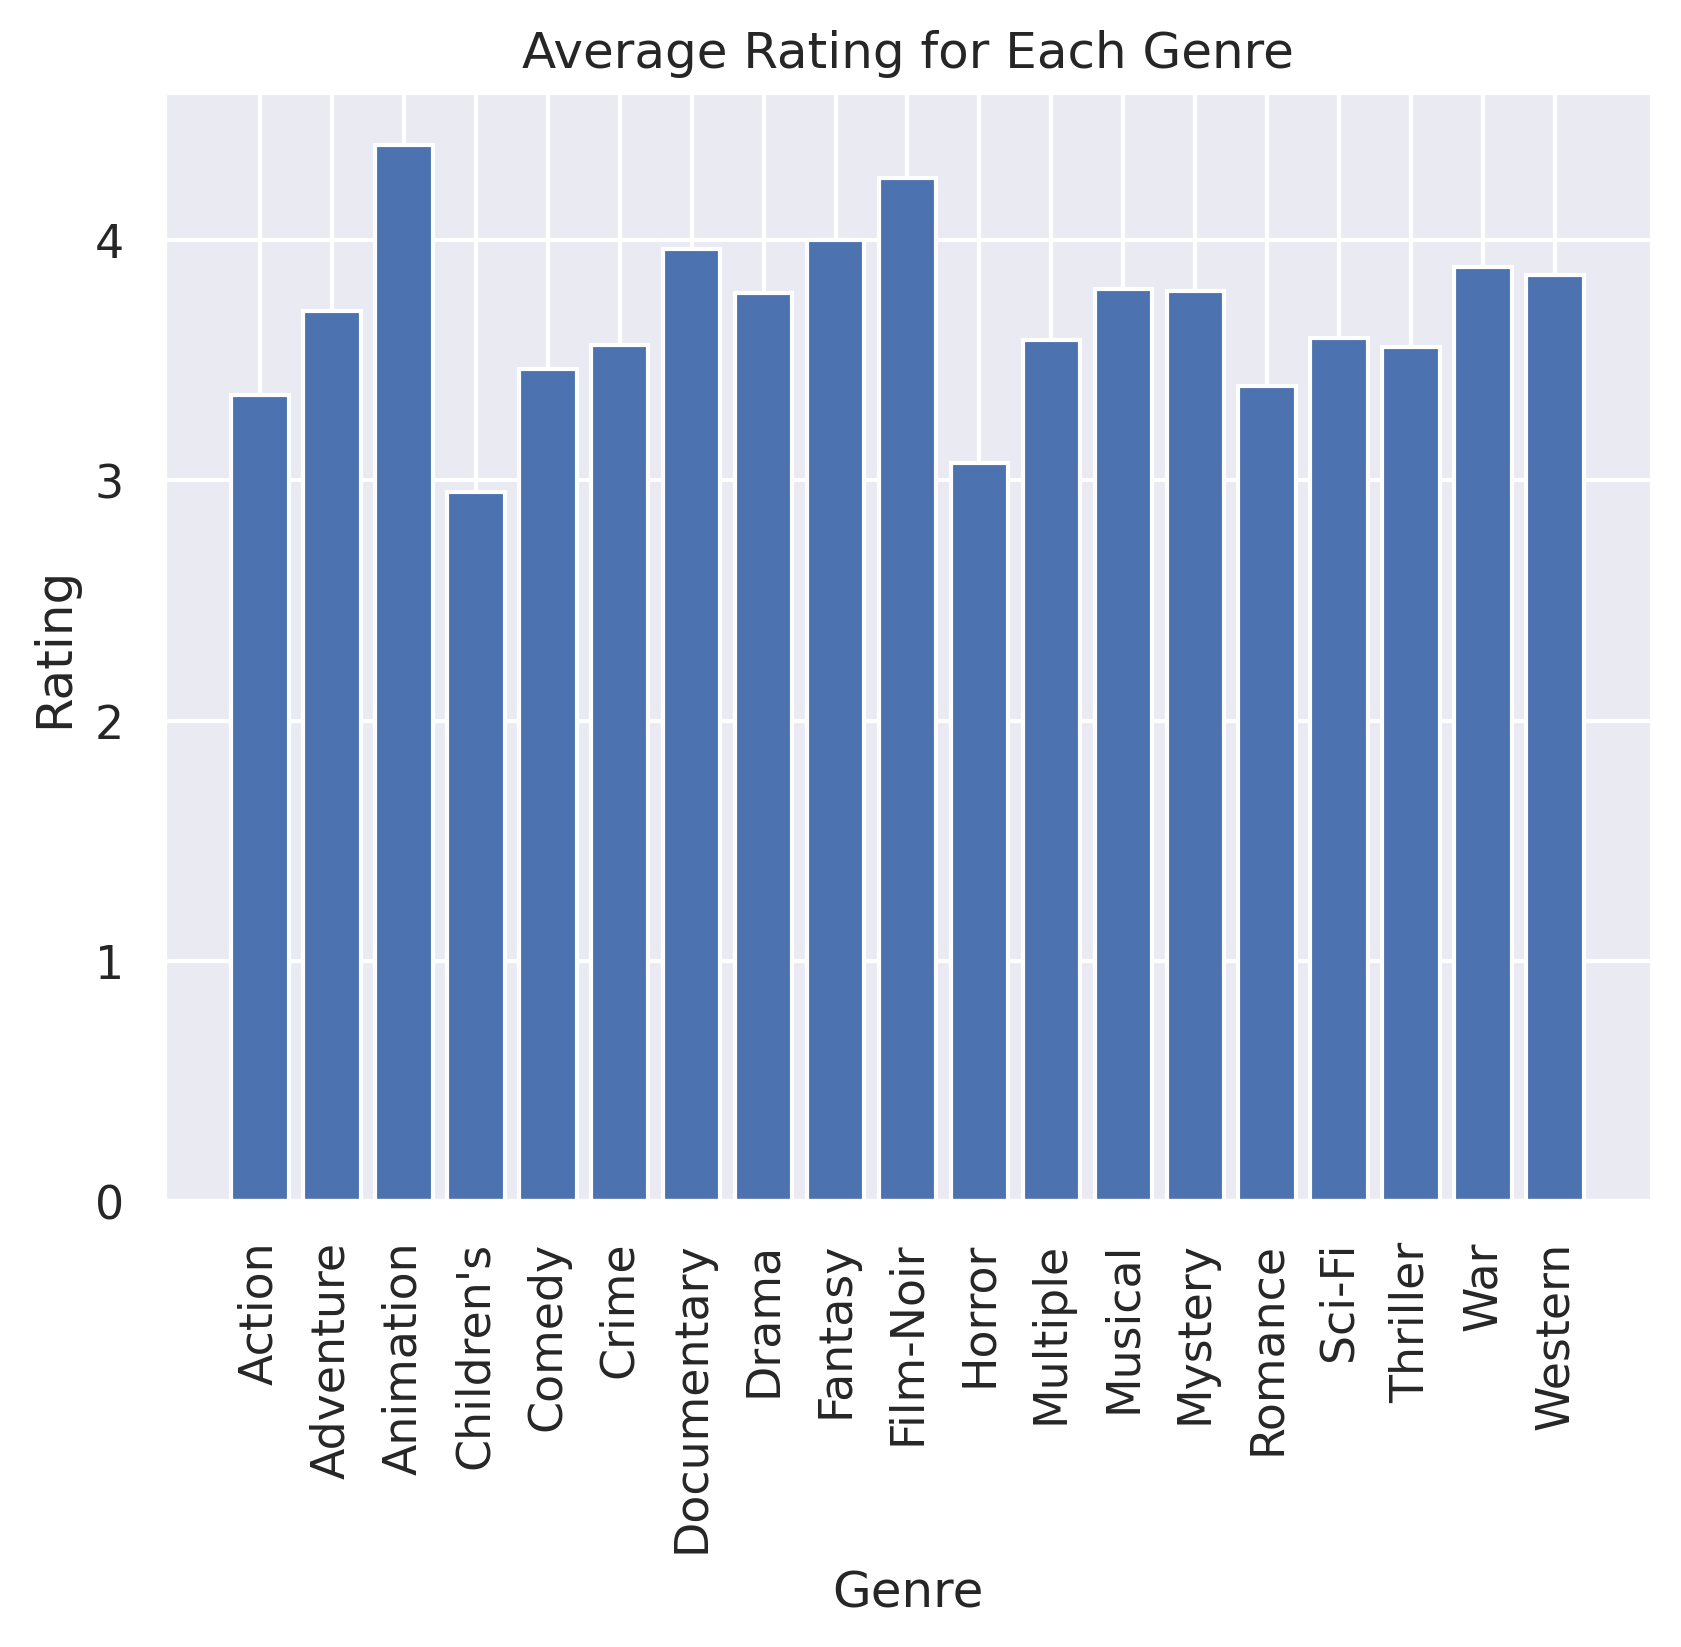

In [18]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 300
sns.set()

rating_merged = ratings.merge(movies, left_on = 'MovieID', right_on = 'MovieID')
mean_ratings = rating_merged[['Rating', 'Genres']].groupby('Genres').mean()

plt.bar(mean_ratings.index, mean_ratings['Rating']);
plt.xticks(rotation=90);
plt.title('Average Rating for Each Genre');
plt.xlabel('Genre');
plt.ylabel('Rating');

In [19]:
rating_merged

,UserID,MovieID,Rating,Timestamp,Title,Genres
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,978302109,James and the Giant Peach (1996),Multiple
2,1,914,3,978301968,My Fair Lady (1964),Multiple
3,1,3408,4,978300275,Erin Brockovich (2000),Drama
4,1,2355,5,978824291,"Bug's Life, A (1998)",Multiple
...,...,...,...,...,...,...
1000204,6040,1091,1,956716541,Weekend at Bernie's (1989),Comedy
1000205,6040,1094,5,956704887,"Crying Game, The (1992)",Multiple
1000206,6040,562,5,956704746,Welcome to the Dollhouse (1995),Multiple
1000207,6040,1096,4,956715648,Sophie's Choice (1982),Drama


In [20]:
mean_ratings

,Rating
Genres,
Action,3.354886
Adventure,3.704851
Animation,4.394336
Children's,2.951724
Comedy,3.464456
Crime,3.563790
Documentary,3.960734
Drama,3.780611
Fantasy,4.000000


##Compute Popularity Scores

To compute the popularity score for each movie, I use the formula:


Popularity Score=(Number of Ratings)×(Normalized Average Rating)
Where:

Normalized Average Rating: We normalize the average rating to a 0-1 scale (e.g., a rating scale from 1 to 5).
Number of Ratings: This is the count of how many ratings a movie has received.

In [21]:
# Calculate the number of ratings and the average rating for each movie
movie_stats = rating_merged.groupby('MovieID').agg(
    num_ratings=('Rating', 'count'),
    avg_rating=('Rating', 'mean')
).reset_index()

In [22]:
movie_stats

,MovieID,num_ratings,avg_rating
0,1,2077,4.146846
1,2,701,3.201141
2,3,478,3.016736
3,4,170,2.729412
4,5,296,3.006757
...,...,...,...
3701,3948,862,3.635731
3702,3949,304,4.115132
3703,3950,54,3.666667
3704,3951,40,3.900000


In [23]:
# Normalize the average rating (assuming a rating scale of 1-5)
movie_stats['normalized_rating'] = (movie_stats['avg_rating'] - 1) / 4  # Normalize to [0,1] range
movie_stats

,MovieID,num_ratings,avg_rating,normalized_rating
0,1,2077,4.146846,0.786712
1,2,701,3.201141,0.550285
2,3,478,3.016736,0.504184
3,4,170,2.729412,0.432353
4,5,296,3.006757,0.501689
...,...,...,...,...
3701,3948,862,3.635731,0.658933
3702,3949,304,4.115132,0.778783
3703,3950,54,3.666667,0.666667
3704,3951,40,3.900000,0.725000


In [24]:
# Calculate the popularity score
movie_stats['popularity_score'] = movie_stats['num_ratings'] * movie_stats['normalized_rating']
movie_stats

,MovieID,num_ratings,avg_rating,normalized_rating,popularity_score
0,1,2077,4.146846,0.786712,1634.00
1,2,701,3.201141,0.550285,385.75
2,3,478,3.016736,0.504184,241.00
3,4,170,2.729412,0.432353,73.50
4,5,296,3.006757,0.501689,148.50
...,...,...,...,...,...
3701,3948,862,3.635731,0.658933,568.00
3702,3949,304,4.115132,0.778783,236.75
3703,3950,54,3.666667,0.666667,36.00
3704,3951,40,3.900000,0.725000,29.00


In [25]:
# Merge with movie titles to get more useful information
movie_popularity = movie_stats.merge(movies[['MovieID', 'Title']], on='MovieID')
# Sort by popularity score and select the top 10 movies
top_10_popular_movies = movie_popularity.sort_values(by='popularity_score', ascending=False).head(10)
# Display the top 10 popular movies
print(top_10_popular_movies[['MovieID', 'Title', 'num_ratings', 'avg_rating', 'popularity_score']])


      MovieID                                              Title  num_ratings  \
2651     2858                             American Beauty (1999)         3428   
253       260          Star Wars: Episode IV - A New Hope (1977)         2991   
1106     1196  Star Wars: Episode V - The Empire Strikes Back...         2990   
1848     2028                         Saving Private Ryan (1998)         2653   
1108     1198                     Raiders of the Lost Ark (1981)         2514   
1120     1210  Star Wars: Episode VI - Return of the Jedi (1983)         2883   
579       593                   Silence of the Lambs, The (1991)         2578   
2374     2571                                 Matrix, The (1999)         2590   
2557     2762                            Sixth Sense, The (1999)         2459   
593       608                                       Fargo (1996)         2513   

      avg_rating  popularity_score  
2651    4.317386           2843.00  
253     4.453694           2582.50

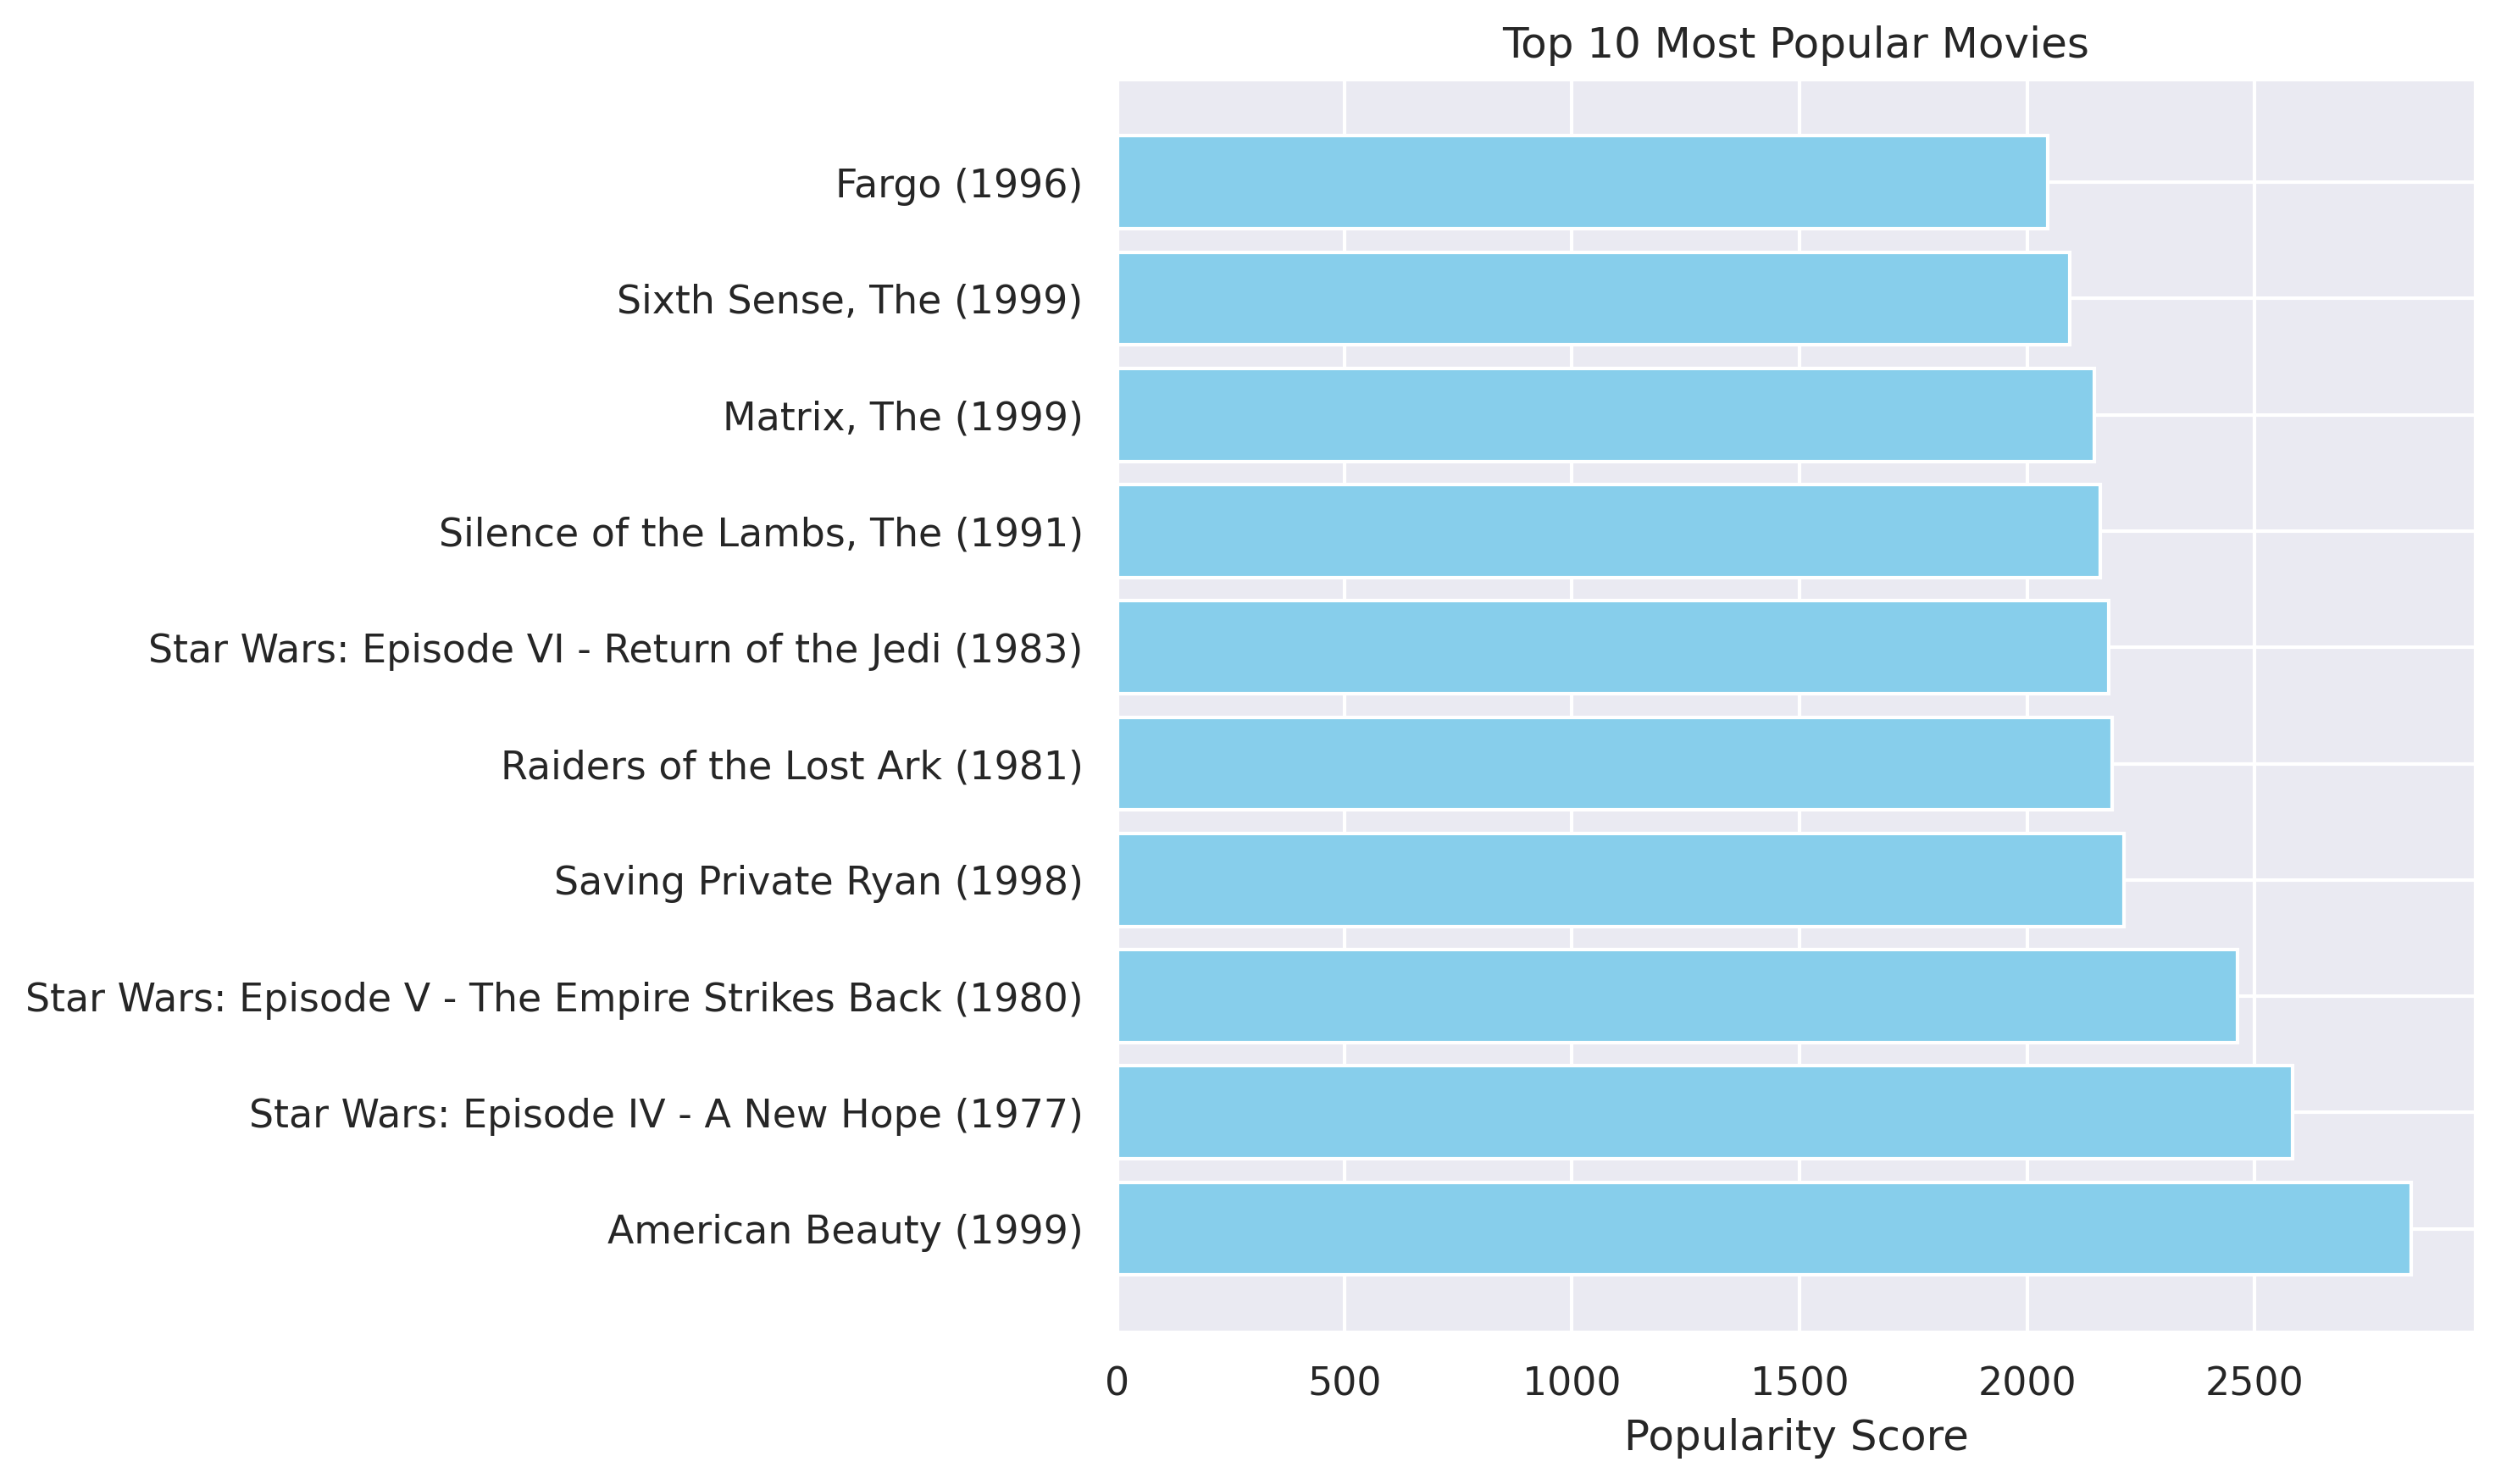

In [26]:
# Visualize the Top 10 Popular Movies
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(top_10_popular_movies['Title'], top_10_popular_movies['popularity_score'], color='skyblue')
ax.set_xlabel('Popularity Score')
ax.set_title('Top 10 Most Popular Movies')
plt.tight_layout()
plt.show()

Recommender System


We train a recommender system and make prediction on the test data. We will use the surprise library. First, we must create a dataset object. To do so, we start with a dataframe with columns itemID, userID and rating and use the load_from_df method.



In [27]:
from surprise import Dataset, Reader
ratings = ratings.drop('Timestamp', axis = 1)
ratings.columns = ['userID', 'itemID', 'rating']
ratings = ratings[['itemID', 'userID', 'rating']]
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[["userID", "itemID", "rating"]], reader)

In [28]:
ratings

,itemID,userID,rating
0,1193,1,5
1,661,1,3
2,914,1,3
3,3408,1,4
4,2355,1,5
...,...,...,...
1000204,1091,6040,1
1000205,1094,6040,5
1000206,562,6040,5
1000207,1096,6040,4


In [29]:
data

Next, we will split the data into a train and test.



In [30]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size = 0.25)


We'll use the user-based collaborative filtering method with cosine similarity and normalization.



In [31]:
from surprise.prediction_algorithms.knns import KNNWithZScore
sim_options = {'name': 'cosine', 'user_based': True}
algo = KNNWithZScore(sim_options=sim_options).fit(trainset)


Computing the cosine similarity matrix...
Done computing similarity matrix.


Now let’s make prediction on the test data:



In [32]:
preds = [algo.predict(uid, iid).est for uid, iid, _ in testset]
results_table = pd.DataFrame(np.stack([testset])[0],
                             columns = ['itemID', 'userID', 'rating'])
results_table['predicted'] = preds
results_merged = results_table.merge(movies,
                                     left_on = 'itemID', right_on = 'MovieID')
results_merged = results_merged.drop('itemID', axis = 1)
results_merged.sort_values('userID')

,userID,rating,predicted,MovieID,Title,Genres
28488,1.0,4.0,3.583249,2994,"City, The (1998)",Drama
121233,1.0,5.0,4.197347,1054,Get on the Bus (1996),Drama
61615,1.0,4.0,3.961181,3464,Solar Crisis (1993),Multiple
77472,1.0,5.0,4.426396,2966,"Straight Story, The (1999)",Drama
138079,1.0,5.0,3.771467,2873,Lulu on the Bridge (1998),Multiple
...,...,...,...,...,...,...
67057,3952.0,2.0,3.926032,127,"Silence of the Palace, The (Saimt el Qusur) (1...",Drama
111948,3952.0,1.0,3.283967,1626,Fire Down Below (1997),Multiple
84513,3952.0,5.0,3.207616,1877,Little Men (1998),Drama
109082,3952.0,5.0,4.138470,2841,Stir of Echoes (1999),Thriller


**System II: Recommendation Based on IBCF**

denote the 6040-by-3706 rating matrix

In [42]:
rating_matrix = ratings.pivot(index='userID', columns='itemID', values='rating')
rating_matrix.shape

(6040, 3706)

In [45]:
rating_matrix

itemID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
userID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Normalize the rating matrix by centering each row. Row means should be computed based on non-NA entries

In [46]:
rating_matrix.mean(axis=1,skipna=True)

,0
userID,
1,4.188679
2,3.713178
3,3.901961
4,4.190476
5,3.146465
...,...
6036,3.302928
6037,3.717822
6038,3.800000


In [47]:
rating_matrix_norm = rating_matrix-rating_matrix.mean(axis=1,skipna=True)
rating_matrix_norm

,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
userID,,,,,,,,,,,,,,,,,,,,,
1,0.811321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,-1.901408,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,NaN,NaN,NaN,-2.190476,NaN,-0.901408,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
#get a list of all movie id and user id
itemID_lst = rating_matrix.columns
userID_lst = rating_matrix.index

In [81]:
card_check = len(userID_lst) - rating_matrix_norm.isna().sum()
card_check[card_check >2]

,0
1,2077
2,701
3,478
4,170
5,296
...,...
3948,862
3949,304
3950,54
3951,40


Let S denote the 3706-by-3706 similarity matrix

In [50]:
s_matrix = np.full((len(itemID_lst), len(itemID_lst)), np.nan)
s_matrix.shape

(3706, 3706)

In [70]:
total_count = len(itemID_lst)*len(itemID_lst)
print(f"total_count = {total_count}")

total_count = 13734436


In [ ]:
from datetime import datetime

# Start time (past)
start_time = datetime.now()
print(f'Start Time:{start_time}')

# Current time

count = 0
for i, movie_i in enumerate(itemID_lst):
  for j, movie_j in enumerate(itemID_lst):
    count += 1
    if count % 50000 == 0:
      current_time = datetime.now()
      print(f"count = {count} at time = {current_time}")
    temp_matrix = rating_matrix_norm.loc[:,[movie_i,movie_j]]
    temp_matrix = temp_matrix.dropna()
    if len(temp_matrix) < 3:
      s_matrix[i,j] = np.nan
    else:
      rli_rlj = (temp_matrix.iloc[:,0]*temp_matrix.iloc[:,1]).sum()
      rli_rli = ((temp_matrix.iloc[:,0]**2).sum())**0.5
      rlj_rlj = ((temp_matrix.iloc[:,1]**2).sum())**0.5

      if rli_rli == 0 or rlj_rlj == 0:
        s_matrix[i,j] = np.nan
      else:
        s_matrix[i,j] =0.5+0.5*(rli_rlj/(rli_rli*rlj_rlj))


Start Time:2024-12-04 03:26:09.932827
count = 50000 at time = 2024-12-04 03:27:39.650231
count = 100000 at time = 2024-12-04 03:29:10.762297
count = 150000 at time = 2024-12-04 03:30:33.528975
count = 200000 at time = 2024-12-04 03:31:59.184277
count = 250000 at time = 2024-12-04 03:33:18.476238
count = 300000 at time = 2024-12-04 03:34:42.213214
count = 350000 at time = 2024-12-04 03:36:04.150499
count = 400000 at time = 2024-12-04 03:37:25.374257
count = 450000 at time = 2024-12-04 03:38:44.920414
count = 500000 at time = 2024-12-04 03:39:49.480052
count = 550000 at time = 2024-12-04 03:41:12.734003


In [ ]:
#save the s_matrix
s_matrix.to_csv(f'{DATA_DIR}/s_matrix.csv')

In [34]:
!pip install dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3


In [72]:
import pandas as pd
import numpy as np

import dash
from dash import dcc, html

In [73]:


DATA_DIR=f"/content/drive/MyDrive/MastersDegree/CS598 PSL/Assignments/Projects/project4/Dataset/ml-1m"
IMAGES_URL=f"/content/drive/MyDrive/MastersDegree/CS598 PSL/Assignments/Projects/project4/Dataset/assets"


ratings = pd.read_csv(f'{DATA_DIR}/ratings.dat', sep='::', engine = 'python', header=None)
ratings.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
movies = pd.read_csv(f'{DATA_DIR}/movies.dat', sep='::', engine = 'python',
                     encoding="ISO-8859-1", header = None)
movies.columns = ['MovieID', 'Title', 'Genres']

movies['PosterURL'] = movies['MovieID'].apply(lambda x: f"{IMAGES_URL}/{x}.jpg")


multiple_idx = pd.Series([("|" in movie) for movie in movies['Genres']])
movies.loc[multiple_idx, 'Genres'] = 'Multiple'

rating_merged = ratings.merge(movies, left_on = 'MovieID', right_on = 'MovieID')
mean_ratings = rating_merged[['Rating', 'Genres']].groupby('Genres').mean()


# Calculate the number of ratings and the average rating for each movie
movie_stats = rating_merged.groupby('MovieID').agg(
    num_ratings=('Rating', 'count'),
    avg_rating=('Rating', 'mean')
).reset_index()

# Normalize the average rating (assuming a rating scale of 1-5)
movie_stats['normalized_rating'] = (movie_stats['avg_rating'] - 1) / 4  # Normalize to [0,1] range
# Calculate the popularity score
movie_stats['popularity_score'] = movie_stats['num_ratings'] * movie_stats['normalized_rating']
# Merge with movie titles to get more useful information
movie_popularity = movie_stats.merge(movies[['MovieID', 'Title','PosterURL']], on='MovieID')
# Sort by popularity score and select the top 10 movies
top_10_popular_movies = movie_popularity.sort_values(by='popularity_score', ascending=False).head(10)
# Display the top 10 popular movies
print(top_10_popular_movies[['MovieID', 'Title', 'num_ratings', 'avg_rating', 'popularity_score', 'PosterURL']])

# Create a Dash app
app = dash.Dash(__name__)

# For deployment

server=app.server

# Layout of the Dash app
app.layout = html.Div(children=[
    html.H1("Top 10 Most Popular Movies"),
    html.Div(
        className="movie-grid",
        children=[
            html.Div(
                className="movie-card",
                children=[
                    html.Img(src=row['PosterURL'], style={'width': '150px', 'height': '225px'}),
                    html.H3(row['Title']),
                    html.P(f"Movie ID: {row['MovieID']}"),
                    html.P(f"Popularity: {row['popularity_score']:.2f}")
                ]
            ) for index, row in top_10_popular_movies.iterrows()
        ],
        style={'display': 'grid', 'gridTemplateColumns': 'repeat(5, 1fr)', 'gap': '20px', 'padding': '20px'}
    )
])
# Run the server
if __name__ == '__main__':
    app.run_server(debug=True, host='127.0.0.1', port=9000)

      MovieID                                              Title  num_ratings  \
2651     2858                             American Beauty (1999)         3428   
253       260          Star Wars: Episode IV - A New Hope (1977)         2991   
1106     1196  Star Wars: Episode V - The Empire Strikes Back...         2990   
1848     2028                         Saving Private Ryan (1998)         2653   
1108     1198                     Raiders of the Lost Ark (1981)         2514   
1120     1210  Star Wars: Episode VI - Return of the Jedi (1983)         2883   
579       593                   Silence of the Lambs, The (1991)         2578   
2374     2571                                 Matrix, The (1999)         2590   
2557     2762                            Sixth Sense, The (1999)         2459   
593       608                                       Fargo (1996)         2513   

      avg_rating  popularity_score  \
2651    4.317386           2843.00   
253     4.453694           2582.

<IPython.core.display.Javascript object>